In [1]:
import process as pc

positive_images_path = pc.DATA_PATH+"/img_align_celeba"

pc.extract_dataset(positive_images_path)
img_list = pc.load_images(number_of_images=100, random_seed=7)
images = []
for img in img_list:
    images.append(pc.process_image(pc.DATA_PATH+"/img_align_celeba/"+img))

CelebA dataset already extracted


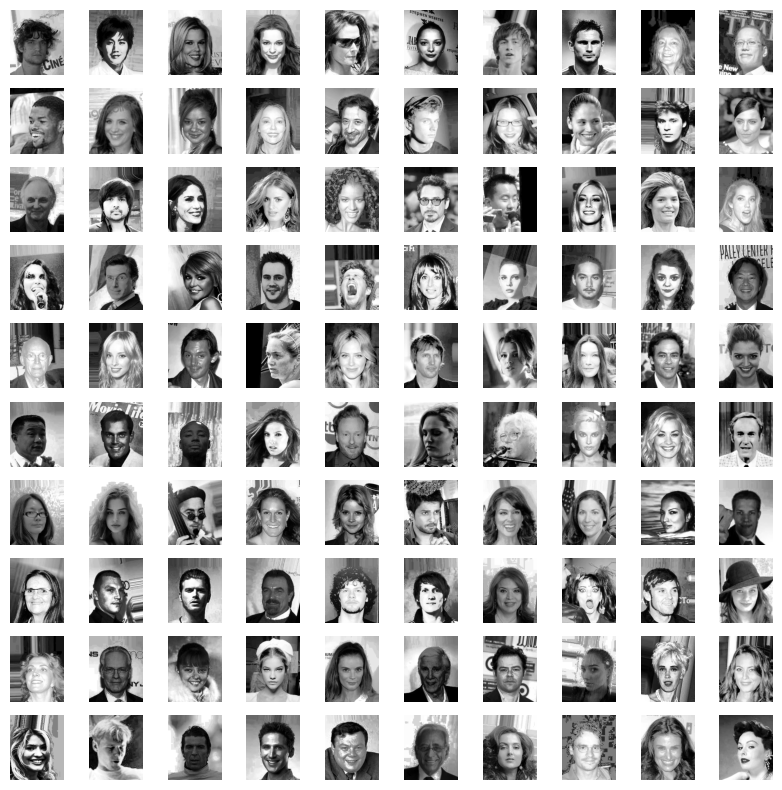

In [2]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images[i*10+j], cmap='gray')
        ax[i, j].axis('off')